In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import math

# Data processing

In [2]:
# Reading users file
u_cols = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
users = pd.read_csv('/Applications/codingforlife/semester4/ML/project/MachineLearning/dataset/users.dat', sep='::', names=u_cols, encoding='latin-1', engine='python')
n_users = users.shape[0]
n_users

6040

In [3]:
# Reading ratings file
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings_base = pd.read_csv('/Applications/codingforlife/semester4/ML/project/MachineLearning/dataset/ratings.dat', sep='::', names=r_cols, encoding='latin-1', engine='python')
ratings = ratings_base.to_numpy()
rate_train, rate_test = train_test_split(ratings, test_size=0.1, stratify=ratings[:,0])
ratings

array([[        1,      1193,         5, 978300760],
       [        1,       661,         3, 978302109],
       [        1,       914,         3, 978301968],
       ...,
       [     6040,       562,         5, 956704746],
       [     6040,      1096,         4, 956715648],
       [     6040,      1097,         4, 956715569]])

In [4]:
mean = np.array([np.mean(ratings[:,2][ratings[:,0]==1]) for i in range(n_users)])

In [6]:
# Reading movies file
i_cols = ['movie id', 'movie title', 'genres']
movies = pd.read_csv('/Applications/codingforlife/semester4/ML/project/MachineLearning/dataset/movies.dat', sep='::', names=i_cols, encoding='latin-1', engine='python')
genres_columns = movies['genres'].str.get_dummies(sep='|')
movies = pd.concat([movies, genres_columns], axis=1)
movies = movies.drop('genres', axis=1)
n_movies = max(movies['movie id'])
n_movies

3952

Handle missing data

In [7]:
#Find and insert missing data to the dataframe with: movie title = 'XXX' and all values in genre column = '0'
existing_ids = movies['movie id'].tolist()
missing_ids = [id for id in range(1, max(existing_ids) + 1) if id not in existing_ids]
missing_data = pd.DataFrame({'movie id': missing_ids, 'movie title': 'XXX'})
missing_data = pd.concat([missing_data, pd.DataFrame(0, index=np.arange(len(missing_data)), columns=genres_columns.columns)], axis=1)
movies = pd.concat([movies, missing_data], ignore_index=True)


# Prediction


In [8]:
#Since we rely on the movie genre to build our profile, we'll only be interested in the 18 binary values at the end of each row:
genre = 18
X0 = movies.to_numpy()
X_train_counts = X0[:, -genre:]
X_train_counts

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object)

In [9]:
#tfidf
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
tfidf = transformer.fit_transform(X_train_counts.tolist()).toarray()


def get_items_rated_by_user(rate_matrix, user_id):
    y = rate_matrix[:,0]
    ids = np.where(y == user_id +1)[0]
    item_ids = rate_matrix[ids, 1] - 1
    scores = rate_matrix[ids, 2]
    item_ids = item_ids[np.argsort(scores)]
    scores = sorted(scores)
    return (item_ids[::-1], scores[::-1])

d = tfidf.shape[1] # data dimension
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))




In [10]:
def predict(alpha):
    for n in range(n_users):
        ids, scores = get_items_rated_by_user(rate_train, n)
        clf = Ridge(alpha=alpha, fit_intercept  = True)
        Xhat = tfidf[ids, :]

        clf.fit(Xhat, scores)
        W[:, n] = clf.coef_
        b[0, n] = clf.intercept_
    #Predicted scores
    Yhat = tfidf.dot(W) + b
    return Yhat

# Evaluate model

In [11]:
def RMSE(Y, rates):
    se = 0
    cnt = 0
    for n in range(n_users):
        ids, scores_truth = get_items_rated_by_user(rates, n)
        scores_pred = Y[ids, n]
        e = scores_truth - scores_pred
        se += (e*e).sum(axis = 0)
        cnt += e.size
    return math.sqrt(se/cnt)

In [12]:
def MAE(Y, rates):
    se = 0
    cnt = 0
    for n in range(n_users):
        ids, scores_truth = get_items_rated_by_user(rates, n)
        scores_pred = Y[ids, n]
        e = abs(scores_truth - scores_pred )
        se += e.sum(axis = 0)
        cnt += e.size
    return math.sqrt(se/cnt)

In [13]:
def metrics(n, rate_test):
    # rate_test = rate_test[:n]
    tp=0
    tp_fp=0
    tp_fn=0
    precision = 0
    recall = 0
    f1 = 0
    para = 0.05
    for r in rate_test:
        trueRate = r[2]-mean[r[0]-1]
        predictRate = Yhat[r[1]-1,r[0]-1]-mean[r[0]-1]
        if predictRate>para:
            tp_fp+=1
        if trueRate>para:
            tp_fn += 1
            if predictRate>para:
                tp+=1
    if tp_fp!=0:
        precision = tp/tp_fp
    if tp_fn!=0:
        recall = tp/tp_fn
    if precision+recall != 0:
        f1 = 2* precision * recall/(precision+recall)
    # print('Precision    :', precision)
    # print('Reacll       :', recall)
    # print('NDCG         :', NDCG)
    return (precision, recall, f1)

In [14]:
def metrics(Y):
    tp=0
    tp_fp=0
    tp_fn=0
    para = 0.05
    for r in rate_test:
        trueRate = r[2]-mean[r[0]-1]
        predictRate = Y[r[1]-1,r[0]-1]-mean[r[0]-1]
        if predictRate>para:
            tp_fp+=1
        if trueRate>para:
            tp_fn += 1
            if predictRate>para:
                tp+=1
    precision = tp/tp_fp
    recall = tp/tp_fn
    f1 = 2*precision*recall/(precision+recall)
    return (precision, recall,f1)

In [15]:
def NDCG(Y):
    rcm_movie_test = np.argsort(-(user_item_test))
    rcm_movie = np.argsort(Y.T)
    ndcg=[]
    for u in range(n_users):
        dcg=0
        idcg=0
        rcm_test = rcm_movie_test[u][np.in1d(rcm_movie_test[u], np.argwhere(~np.isnan(user_item_test[u])))]
        rcm = rcm_movie[u][np.in1d(rcm_movie[u], rcm_test)]
        for i in range(len(rcm)):
            dcg += (2**user_item_test[u][rcm[i]]-1)/math.log(i+2, 2)
            idcg += (2**user_item_test[u][rcm_test[i]]-1)/math.log(i+2, 2)
        ndcg.append(dcg/idcg)
    return np.mean(ndcg)

In [ ]:
def MAP

In [16]:
c = 0
for i in rcm_movie[0]:
    if not np.isnan(user_item_test[0][i]):
        if i in rcm_movie_test[0]:
            c+=1

c/len(rcm_movie[0][:100])

NameError: name 'rcm_movie' is not defined

In [17]:
user_item = np.full((n_users,n_movies),np.nan)
for r in rate_train:
    user_item[r[0]-1][r[1]-1] = r[2]

user_item_test = np.full((n_users,n_movies),np.nan)
for r in rate_test:
    user_item_test[r[0]-1][r[1]-1] = r[2]
user_item_test

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 3., nan, nan, ..., nan, nan, nan]])

In [ ]:
rmse_train = []
rmse_test =[]
mae_train=[]
mae_test=[]
precision=[]
recall=[]
f1=[]
ndcg=[]

iteration_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 30, 50]

for a in iteration_list:
    Yhat = predict(a)
    rmse_train.append(RMSE(Yhat, rate_train))
    rmse_test.append(RMSE(Yhat, rate_test))
    mae_train.append(MAE(Yhat, rate_train))
    mae_test.append(MAE(Yhat, rate_test))
    metric = metrics(Yhat)
    precision.append(metric[0])
    recall.append(metric[1])
    f1.append(metric[2])
    ndcg.append(NDCG(Yhat))


RMSE:  [0.9691241066374477, 0.9691490211409759, 0.9691957754014381, 0.9696862441287881, 0.9703170077231283, 0.9745617208303555, 0.9785319495128438, 0.9939258293325526, 1.0019732130047845, 1.006513076646754, 1.0134038301652961, 1.0175267972319064]
RMSE:  [1.1143806520506758, 1.110949021289559, 1.1081959072585341, 1.0975896481154805, 1.09122098908329, 1.073024150820189, 1.0644143045814434, 1.0468452100712806, 1.0416925096615797, 1.0394837843100053, 1.0369315739107745, 1.0358371263200543]


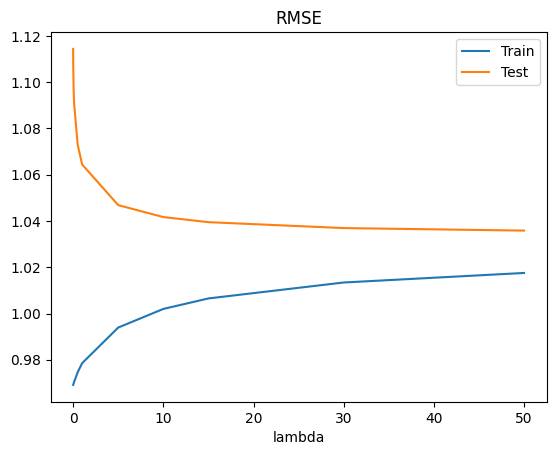

In [ ]:
import matplotlib.pyplot as plt
from importlib import reload
print("RMSE: ",rmse_train)
print("RMSE: ",rmse_test)
plt=reload(plt)
plt.plot(iteration_list, rmse_train, label = 'Train')
plt.plot(iteration_list, rmse_test, label = 'Test')
plt.xlabel('lambda')
plt.title('RMSE')
plt.legend()
plt.show()

Precision:  [0.4092375772102886, 0.409292444116017, 0.4095326237852846, 0.41111530477448577, 0.41468330134357007, 0.42570532915360504, 0.4384815275110157, 0.4852963128825198, 0.5056368837287565, 0.5124933545986178, 0.525112443778111, 0.5348125478194338]
Recall:  [0.19693877551020408, 0.19658385093167702, 0.1963176574977817, 0.1933007985803017, 0.1917036379769299, 0.18074534161490682, 0.17218278615794144, 0.14423247559893523, 0.13331854480922803, 0.12830523513753328, 0.12431233362910382, 0.12404614019520852]
F1:  []


ValueError: ignored

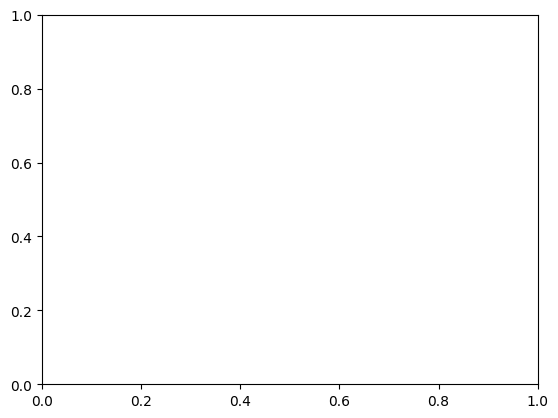

In [ ]:
print("Precision: ",precision)
print("Recall: ",recall)
print("F1: ",f1)
plt=reload(plt)
plt.plot(neighbors, precision, label = 'Precision')
plt.plot(neighbors, recall, label ='Recall')
plt.plot(neighbors, f1,label='F1')
plt.xlabel('Number of movies')
# plt.title('Precision')
plt.legend()
plt.show()

In [ ]:
print("Recall: ",recall)
plt=reload(plt)
plt.plot(iteration_list, recall)
plt.xlabel('lambda')
plt.title('Recall')
plt.show()